# Plan

1. Figures on missing data
    - How many sites do not have any data at all from March - November
    - How many sites do not have any data within x number of pixels
    - % coverage for sites across time
    
2. Decide what to do with missing data

3. Feature: Get one figure for every time + site pair
    - Mean / Median / Quantile of non-missing data around the point (all 11 x 11 pixels)
    - Mean / Median / Quantile of non-missing data around the point (less pixels, maybe 3 x 3 / 5 x 5)

Post Feature Extraction:
1. EDA
2. Binary Classifier

In [173]:
import pandas as pd
import numpy as np
from functools import reduce

# Load Dataset

In [109]:
# replace with path to sites_data_11x11.csv
df = pd.read_csv("/Users/SallyLai/Desktop/LSE/Masters/Capstone/capstone-project-sewage-pollution/copernicus_code/sites_data_11x11.csv")
df['Pixel Index'] = np.arange(1,122).tolist() * 430 * 237
df

,time,lat,lon,TUR,SPM,CHL,site,Pixel Index
0,2022-03-01,55.189352,-1.519043,NaN,NaN,NaN,Newbiggin_North,1
1,2022-03-01,55.189352,-1.517296,NaN,NaN,NaN,Newbiggin_North,2
2,2022-03-01,55.189352,-1.515549,NaN,NaN,NaN,Newbiggin_North,3
3,2022-03-01,55.189352,-1.513802,NaN,NaN,NaN,Newbiggin_North,4
4,2022-03-01,55.189352,-1.512055,NaN,NaN,NaN,Newbiggin_North,5
...,...,...,...,...,...,...,...,...
12331105,2022-10-31,50.277315,-3.893256,2.006134,1.186131,1.828091,Bigbury-on-Sea_South,117
12331106,2022-10-31,50.277315,-3.891509,0.708182,0.406647,1.046769,Bigbury-on-Sea_South,118
12331107,2022-10-31,50.277315,-3.889762,1.258156,0.729469,1.327342,Bigbury-on-Sea_South,119
12331108,2022-10-31,50.277315,-3.888015,1.037095,0.598882,1.254974,Bigbury-on-Sea_South,120


In [3]:
len(df['time'].unique())

237

In [4]:
len(df['site'].unique())

430

# Mean, Median, Q1, Q3 for every time + site pair

In [183]:
def mean_median_over_pixel_grid(dim):
    '''
    inputs:
        - Grid dimension (integer, 1 / 3 / 5 / 7 / 9 / 11)
        
    output:
        - dataframe with the following columns:
            - Time
            - Site
            - 12 columns for every combination of TUR/SPM/CHL x median/mean/q1/q3
    '''
    # Dataframe with only relevant pixels based on grid dimension
    i = int((dim-1)/2)
    indices = np.array(range(1,122)).reshape(11,11)[5-i:6+i, 5-i:6+i].flatten()
    df1 = df[df['Pixel Index'].isin(indices)]
    
    # Mean, Median, Quantiles
    median = df1.groupby(['time', 'site']).median().drop(['lat','lon', 'Pixel Index'], axis=1).add_suffix(f'_{dim}x{dim}_median')
    mean = df1.groupby(['time', 'site']).mean().drop(['lat','lon', 'Pixel Index'], axis=1).add_suffix(f'_{dim}x{dim}_mean')
    q1 = df1.groupby(['time', 'site']).quantile(0.25).drop(['lat','lon', 'Pixel Index'], axis=1).add_suffix(f'_{dim}x{dim}_q1')
    q3 = df1.groupby(['time', 'site']).quantile(0.75).drop(['lat','lon', 'Pixel Index'], axis=1).add_suffix(f'_{dim}x{dim}_q3')
    df2 = reduce(lambda  left,right: pd.merge(left,right,on=['time', 'site'],how='outer'), [median, mean, q1, q3])
       
    return df2

In [184]:
%%time
dfs = []

for dim in [1,3,5,7,9,11]:
    dfs.append(mean_median_over_pixel_grid(dim))

CPU times: user 1min 11s, sys: 3.01 s, total: 1min 14s
Wall time: 1min 15s


In [187]:
features_df = reduce(lambda  left,right: pd.merge(left,right,on=['time', 'site'],how='outer'), dfs)
features_df.head()

TUR_1x1_median  SPM_1x1_median  CHL_1x1_median  \
time       site                                                            
2022-03-01 Ainsdale                  NaN             NaN             NaN   
           Allonby                   NaN             NaN             NaN   
           Allonby_South             NaN             NaN             NaN   
           Amble_Links               NaN             NaN             NaN   
           Anderby                   NaN             NaN             NaN   

                          TUR_1x1_mean  SPM_1x1_mean  CHL_1x1_mean  \
time       site                                                      
2022-03-01 Ainsdale                NaN           NaN           NaN   
           Allonby                 NaN           NaN           NaN   
           Allonby_South           NaN           NaN           NaN   
           Amble_Links             NaN           NaN           NaN   
           Anderby                 NaN           NaN           NaN   

                          TUR_1x1_q1  SPM_1x1_q1  CHL_1x1_q1  TUR_1x1_q3  ...  \
time       site                                                           ...   
2022-03-01 Ainsdale              NaN         NaN         NaN         NaN  ...   
           Allonby               NaN         NaN         NaN         NaN  ...   
           Allonby_South         NaN         NaN         NaN         NaN  ...   
           Amble_Links           NaN         NaN         NaN         NaN  ...   
           Anderby               NaN         NaN         NaN         NaN  ...   

                          CHL_11x11_median  TUR_11x11_mean  SPM_11x11_mean  \
time       site                                                              
2022-03-01 Ainsdale                    NaN             NaN             NaN   
           Allonby                     NaN             NaN             NaN   
           Allonby_South               NaN             NaN             NaN   
           Amble_Links                 NaN             NaN             NaN   
           Anderby                     NaN             NaN             NaN   

                          CHL_11x11_mean  TUR_11x11_q1  SPM_11x11_q1  \
time       site                                                        
2022-03-01 Ainsdale                  NaN           NaN           NaN   
           Allonby                   NaN           NaN           NaN   
           Allonby_South             NaN           NaN           NaN   
           Amble_Links               NaN           NaN           NaN   
           Anderby                   NaN           NaN           NaN   

                          CHL_11x11_q1  TUR_11x11_q3  SPM_11x11_q3  \
time       site                                                      
2022-03-01 Ainsdale                NaN           NaN           NaN   
           Allonby                 NaN           NaN           NaN   
           Allonby_South           NaN           NaN           NaN   
           Amble_Links             NaN           NaN           NaN   
           Anderby                 NaN           NaN           NaN   

                          CHL_11x11_q3  
time       site                         
2022-03-01 Ainsdale                NaN  
           Allonby                 NaN  
           Allonby_South           NaN  
           Amble_Links             NaN  
           Anderby                 NaN  

[5 rows x 72 columns]

In [192]:
# rows = 237 (days) x 430 (sites)
# column = 3 (TUR, SPM, CHL) x 4 (mean, median, q1, q3) x 6 (1x1/3x3/5x5/7x7/9x9/11x11)
features_df.shape

(101910, 72)

In [188]:
features_df.to_csv("feature_extraction.csv")

# Quantifying Missing Values

## Sites with no data at all (within 11x11 pixels)

In [189]:
# max count, count = the number of days with data for every site and every feature
max_count = features_df.groupby('site').count().max(axis=1) 

# sites where max count == 0
print(max_count[max_count == 0])
print('\n')
print(f'Count: {len(max_count[max_count == 0])}')

site
Colwick_Country_Park_West_Lake      0
Cotswold_Country_Park_and_Beach     0
Frensham_Great_Pond                 0
Hampstead_Heath_Ladies_Pond         0
Hampstead_Heath_Mens_Pond           0
Hampstead_Heath_Mixed_Pond          0
Henleaze_Lake                       0
The_Serpentine_-_Hyde_Park          0
Wharfe_at_Cromwheel,_Ilkley         0
Windermere,_Fellfoot                0
Windermere,_Lakeside_YMCA           0
Windermere,_Millerground_Landing    0
Windermere,_Rayrigg_Meadow          0
Wolvercote_Mill_Stream              0
dtype: int64


Count: 14


## Sites with no data within x number of pixels

In [190]:
for d in [1,3,5,7,9,11]:
    df_temp = features_df[[f'TUR_{d}x{d}_median', f'SPM_{d}x{d}_median', f'CHL_{d}x{d}_median', f'TUR_{d}x{d}_mean', f'SPM_{d}x{d}_mean', f'CHL_{d}x{d}_mean']]
    
    # max count, count = the number of days with data for every site and every feature
    max_count = df_temp.groupby('site').count().max(axis=1) 

    # print number of sites where max count == 0
    print(f'Sites with no data across 237 days, {d}x{d}: {len(max_count[max_count == 0])}')

Sites with no data across 237 days, 1x1: 272
Sites with no data across 237 days, 3x3: 19
Sites with no data across 237 days, 5x5: 14
Sites with no data across 237 days, 7x7: 14
Sites with no data across 237 days, 9x9: 14
Sites with no data across 237 days, 11x11: 14


## Distribution of Coverage Count (out of 237 days) for sites across time

<Axes: ylabel='Frequency'>

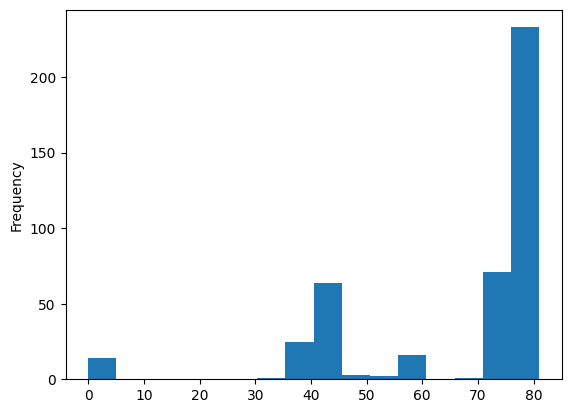

In [193]:
max_count = features_df.groupby('site').count().max(axis=1)
max_count.plot.hist(bins=16)